# yt_xarray 

An xarray "accessor" interface to yt (for gridded data)

* Main docs: https://yt-xarray.readthedocs.io/en/latest/
* 2024 NASA Software Workshop Jupyter Book: [presentation](https://chrishavlin.github.io/NASASoftwareWorkshop2024/intro.html) and [code](https://github.com/data-exp-lab/yt_xarray_NASA_SMD_2024) 

Extra requirements:

```
pip install yt_xarray scipy xarray netCDF4 cartopy
```

```
wget https://yt2025data.hub.yt/geo/wUS-SH-2010_percent.nc
```



In [1]:
import yt_xarray

ds = yt_xarray.open_dataset("IRIS/wUS-SH-2010_percent.nc")
type(ds)

xarray.core.dataset.Dataset

In [2]:
ds

<xarray.Dataset> Size: 2MB
Dimensions:    (depth: 19, latitude: 93, longitude: 122)
Coordinates:
  * depth      (depth) float32 76B 60.0 90.0 125.0 160.0 ... 760.0 820.0 885.0
  * latitude   (latitude) float32 372B 27.5 27.75 28.0 28.25 ... 50.0 50.25 50.5
  * longitude  (longitude) float32 488B -125.8 -125.5 -125.2 ... -95.75 -95.5
Data variables:
    dvp        (depth, latitude, longitude) float32 862kB ...
    dvs        (depth, latitude, longitude) float32 862kB ...
Attributes: (12/32)
    title:                         P and S teleseismic body-wave tomography o...
    id:                            wUS-SH-2010_percent
    summary:                       Teleseismic travel-time residuals from the...
    keywords:                      seismic, tomography, compressional wave, p...
    Conventions:                   CF-1.0
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    ...                            ...
    author_email:                  bschmandt@unm.edu
    author_institution:            Department of Earth and Planetary Science,...
    author_url:                    
    repository_name:               EMC
    repository_institution:        IRIS DMC
    repository_pid:                doi:10.17611/DP/9991760

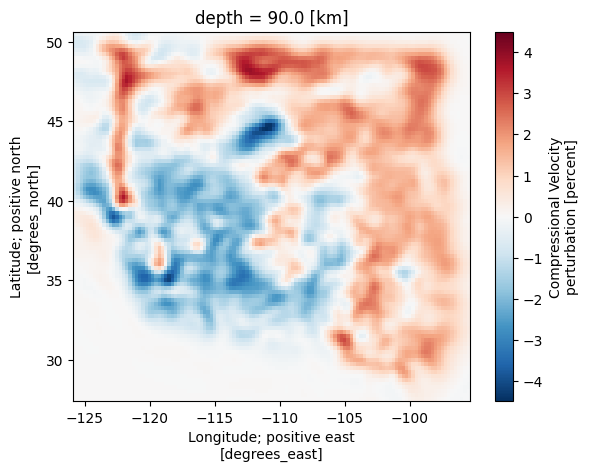

In [3]:
ds.dvp.isel({'depth': 1}).plot()

In [ ]:
ds.yt.

yt_xarray : [INFO ] 2025-07-17 10:52:39,688:  Inferred geometry type is geodetic. To override, use ds.yt.set_geometry
yt_xarray : [INFO ] 2025-07-17 10:52:39,702:  Attempting to detect if yt_xarray will require field interpolation:
yt_xarray : [INFO ] 2025-07-17 10:52:39,703:      stretched grid detected: yt_xarray will interpolate.
yt : [INFO     ] 2025-07-17 10:52:39,876 Parameters: current_time              = 0.0
yt : [INFO     ] 2025-07-17 10:52:39,877 Parameters: domain_dimensions         = [ 18  92 121]
yt : [INFO     ] 2025-07-17 10:52:39,879 Parameters: domain_left_edge          = [  60.     27.5  -125.75]
yt : [INFO     ] 2025-07-17 10:52:39,880 Parameters: domain_right_edge         = [885.   50.5 -95.5]
yt : [INFO     ] 2025-07-17 10:52:39,882 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2025-07-17 10:52:40,332 xlim = -125.750000 -95.500000
yt : [INFO     ] 2025-07-17 10:52:40,333 ylim = 27.500000 50.500000
yt : [INFO     ] 2025-07-17 10:52:40,335 Setting origin


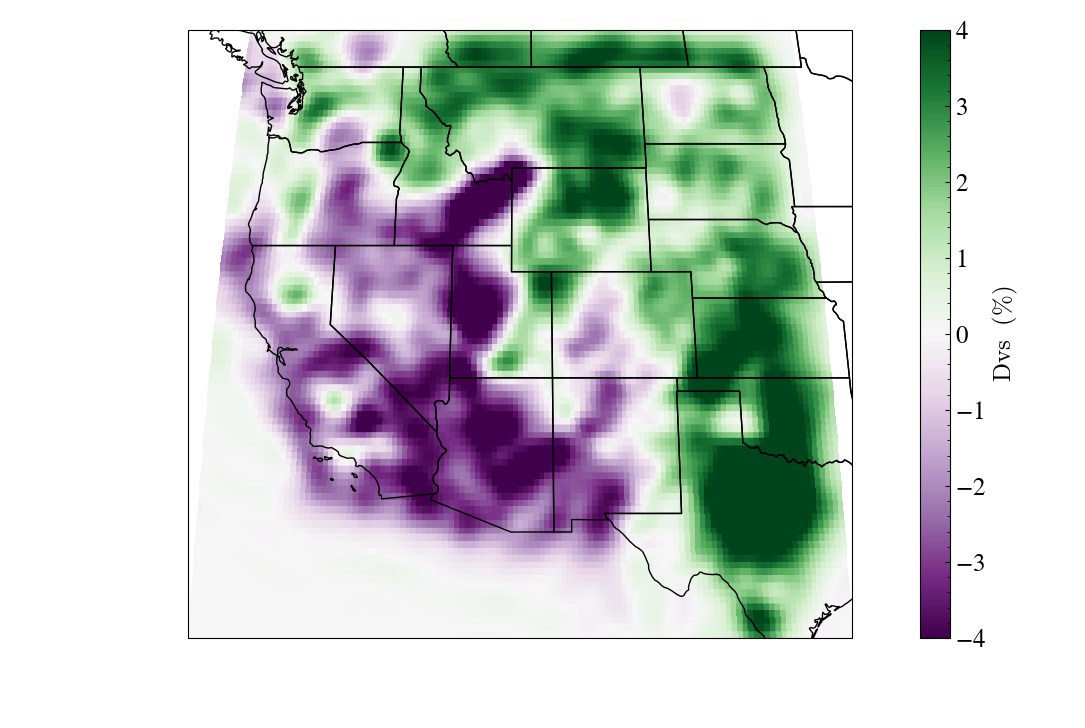

In [4]:
import cartopy.feature as cfeature

c=(125, 39., -110.625)
slc = ds.yt.SlicePlot('depth', 'dvs', center=c)

slc.set_mpl_projection(('Mollweide', (), {'central_longitude':c[2]}))

slc.set_log(('stream', 'dvs'), False)
slc.set_zlim(('stream', 'dvs'), -4, 4)
slc.set_cmap(('stream', 'dvs'), 'PRGn')
slc.render()  # render before making axes modifications 

slc.plots['stream', 'dvs'].axes.add_feature(cfeature.STATES)
 
slc.show()

In [ ]:
ds.yt.PhasePlot

just 3d arrays, can do:

In [5]:
ds_yt = ds.yt.load_grid()

yt_xarray : [INFO ] 2025-07-17 10:53:02,831:  Attempting to detect if yt_xarray will require field interpolation:
yt_xarray : [INFO ] 2025-07-17 10:53:02,833:      stretched grid detected: yt_xarray will interpolate.
yt : [INFO     ] 2025-07-17 10:53:02,994 Parameters: current_time              = 0.0
yt : [INFO     ] 2025-07-17 10:53:02,996 Parameters: domain_dimensions         = [ 18  92 121]
yt : [INFO     ] 2025-07-17 10:53:02,998 Parameters: domain_left_edge          = [  60.     27.5  -125.75]
yt : [INFO     ] 2025-07-17 10:53:03,002 Parameters: domain_right_edge         = [885.   50.5 -95.5]
yt : [INFO     ] 2025-07-17 10:53:03,005 Parameters: cosmological_simulation   = 0


Other datasets

```python
ds_yt = ds.yt.load_grid(sel_dict={'time': 0})
```

In [6]:
ds_yt.coordinates.axis_order

['depth', 'latitude', 'longitude']

In [7]:
ds_yt.coordinates.name

'internal_geographic'


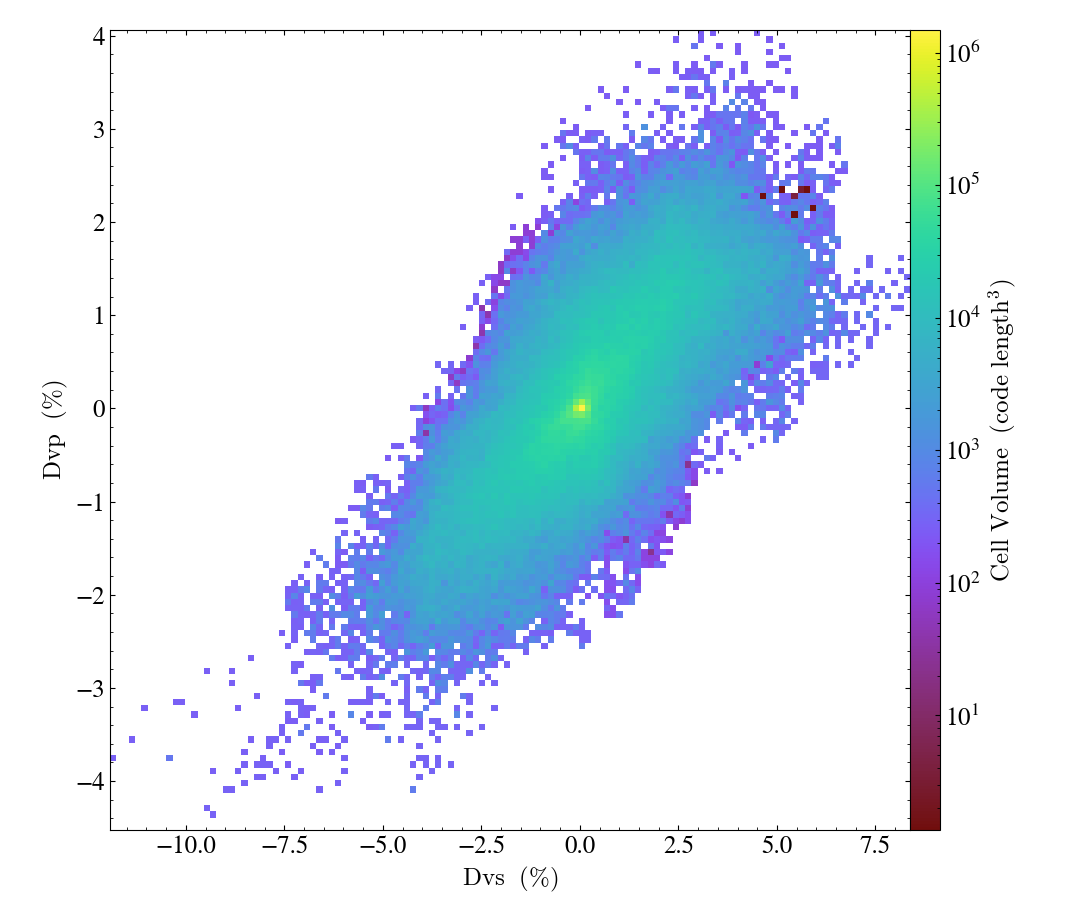

In [8]:
import yt 
p = yt.PhasePlot(ds_yt, 'dvs', 'dvp', ('index', 'cell_volume'), weight_field=None)
p.set_log('dvs', False)
p.set_log('dvp', False)

yt : [INFO     ] 2025-07-17 10:54:27,804 Projection completed
yt : [INFO     ] 2025-07-17 10:54:27,807 xlim = -120.000000 -100.000000
yt : [INFO     ] 2025-07-17 10:54:27,808 ylim = 40.000000 50.000000
yt : [INFO     ] 2025-07-17 10:54:27,809 Setting origin='native' for internal_geographic geometry.
yt : [INFO     ] 2025-07-17 10:54:27,821 xlim = -120.000000 -100.000000
yt : [INFO     ] 2025-07-17 10:54:27,823 ylim = 40.000000 50.000000
yt : [INFO     ] 2025-07-17 10:54:27,828 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800



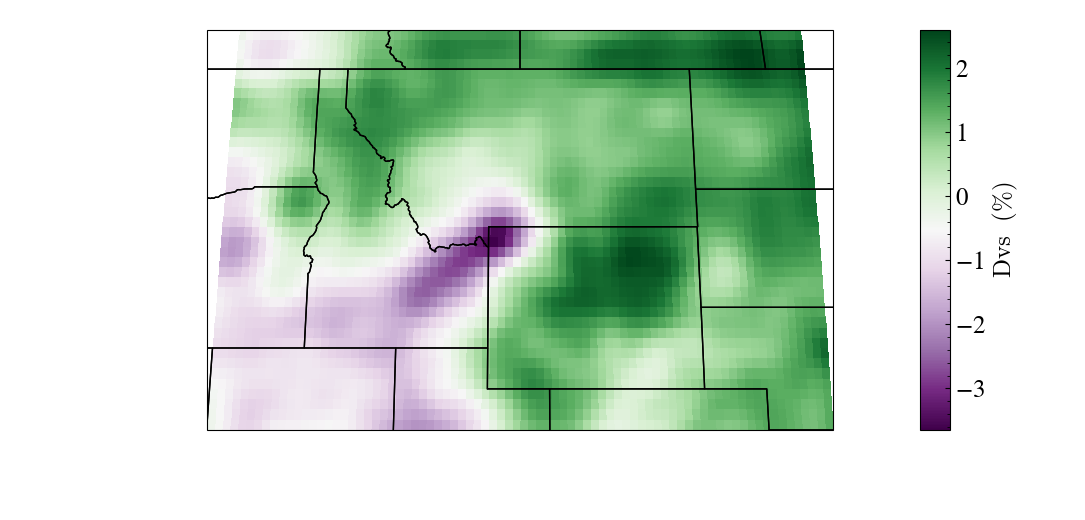

In [9]:
import cartopy.feature as cfeature

ys = ds_yt.arr([90., 45., -110], 'code_length')
wid = ds_yt.arr([ds_yt.domain_width[0].d, 10., 20.], 'code_length')

slc = yt.ProjectionPlot(ds_yt,
                      'depth', 
                      'dvs', 
                      center=ys, 
                      width=(wid[2], wid[1]), 
                      data_source=ds_yt.region(ys, ys-wid/2, ys+wid/2), 
                      weight_field=('index', 'cell_volume'),
                    )

slc.set_mpl_projection(('Mollweide', (), {'central_longitude':ys[2].d}))

slc.set_log(('stream', 'dvs'), False)
slc.set_cmap(('stream', 'dvs'), 'PRGn')
slc.render()  # render before making axes modifications 

slc.plots['stream', 'dvs'].axes.add_feature(cfeature.STATES)
 
slc.show()

## Embedded transformations

In [10]:
from yt_xarray import transformations as tf

gc = tf.GeocentricCartesian(radial_type='depth', r_o=6371., use_neg_lons=True)

ds_yt_cart = tf.build_interpolated_cartesian_ds(
    ds,
    gc,
    fields = 'dvs' ,   
    grid_resolution = (32, 32, 32), 
    refine_grid=True,    
    refine_max_iters=2000,
    refine_min_grid_size=4,
    refine_by=4,
    interp_method='interpolate',
    refinement_method='signature_filter', # use  Berger and Rigoutsos 1991 
)

yt_xarray : [INFO ] 2025-07-17 10:55:50,495:  Creating image mask for grid decomposition.
yt_xarray : [INFO ] 2025-07-17 10:55:51,683:  Decomposing image mask and building yt dataset.
yt_xarray : [INFO ] 2025-07-17 10:55:52,108:  Decomposed into 105 grids after 186 iterations.
yt : [INFO     ] 2025-07-17 10:55:52,236 Parameters: current_time              = 0.0
yt : [INFO     ] 2025-07-17 10:55:52,237 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2025-07-17 10:55:52,238 Parameters: domain_left_edge          = [-3271. -5573.  2533.]
yt : [INFO     ] 2025-07-17 10:55:52,240 Parameters: domain_right_edge         = [ -334. -2832.  4870.]
yt : [INFO     ] 2025-07-17 10:55:52,242 Parameters: cosmological_simulation   = 0


yt : [INFO     ] 2025-07-17 10:55:55,261 xlim = -5573.000000 -2832.000000
yt : [INFO     ] 2025-07-17 10:55:55,263 ylim = 2533.000000 4870.000000
yt : [INFO     ] 2025-07-17 10:55:55,272 xlim = -5573.000000 -2832.000000
yt : [INFO     ] 2025-07-17 10:55:55,273 ylim = 2533.000000 4870.000000
yt : [INFO     ] 2025-07-17 10:55:55,278 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800



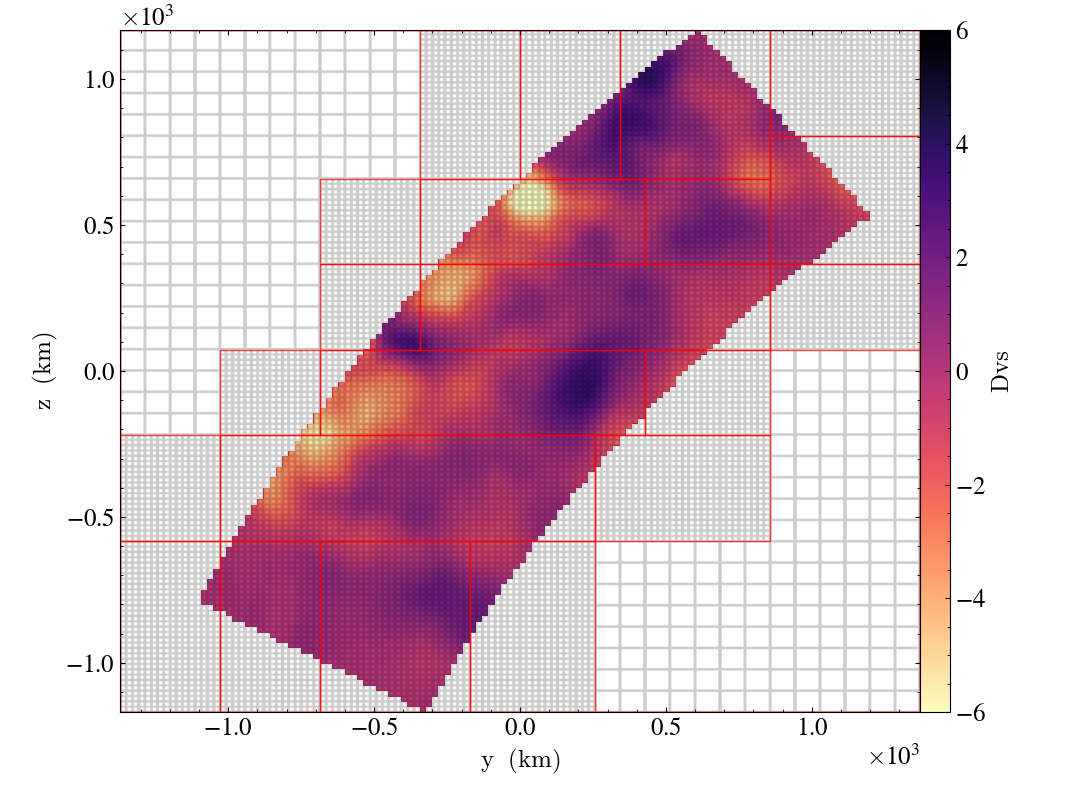

In [11]:
slc = yt.SlicePlot(ds_yt_cart, 'x', ('stream', 'dvs'))
slc.set_log(("stream", "dvs"), False)
slc.set_cmap(("stream", "dvs"), "magma_r")
slc.set_zlim(("stream", "dvs"), -6, 6)
slc.annotate_cell_edges(alpha=0.2)
slc.annotate_grids(edgecolors=(1.,0,0,0))
slc.show()

In [12]:
import numpy as np

def _dvs_not_nan(field, data):
    return ~np.isnan(data['dvs'])

ds_yt_cart.add_field(
    name=("stream", "dvs_not_nan"),
    function=_dvs_not_nan,
    sampling_type="local",
    units='',
    force_override=True,
)

In [ ]:
slc = yt.ProjectionPlot(ds_yt_cart, 'x', ('stream', 'dvs_not_nan'), weight_field=None)
slc.set_log(("stream", "dvs_not_nan"), False)
slc.set_cmap(("stream", "dvs_not_nan"), "octarine")
slc.annotate_grids(edgecolors=(1.,0,0,0))
slc.show()

Can volume render!

First: add a field of just the slow velocity anomalies (<0)

In [ ]:
import numpy
import unyt 

# add a nice field... volume rendering with observational data is hard...
# - fill in nans
# - full dvs is +/-, look at just -, make it + 
def _slow_vels(field, data):    
    dvs = data['dvs'].d.copy()
    dvs[np.isnan(dvs)] = 0.0
    dvs[dvs>0] = 0.0
    return unyt.unyt_array(np.abs(dvs),"")

ds_yt_cart.add_field(
    name=("stream", "slow_dvs"),
    function=_slow_vels,
    sampling_type="local",
    units="",    
)


In [ ]:
sc = yt.create_scene(ds_yt_cart, field=('stream', 'slow_dvs'))
cam = sc.add_camera(ds_yt_cart)

# transfer function 
source = sc[0]
source.tfh.set_bounds((0.1, 8))
source.tfh.set_log(True)

# adjust camera
cam.zoom(2)
cam.yaw(100*np.pi/180)
cam.roll(220*np.pi/180)
cam.rotate(30*np.pi/180)
cam.set_resolution((1000,1000))

sc.show(sigma_clip=5.)